In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

[*********************100%***********************]  1 of 1 completed


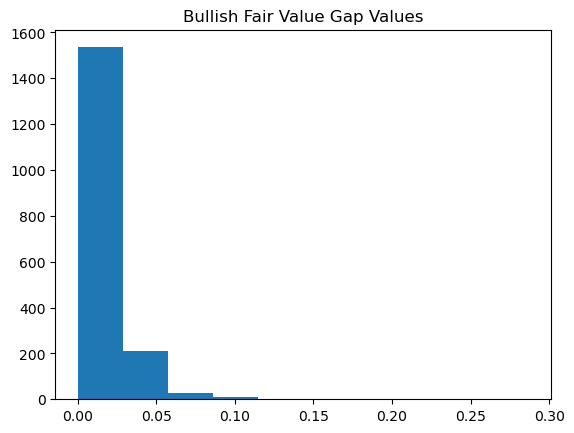

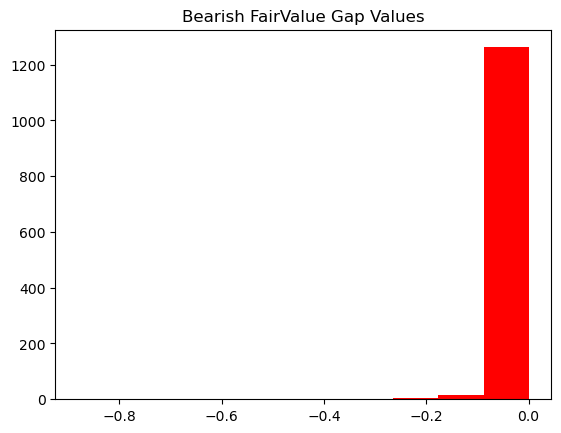

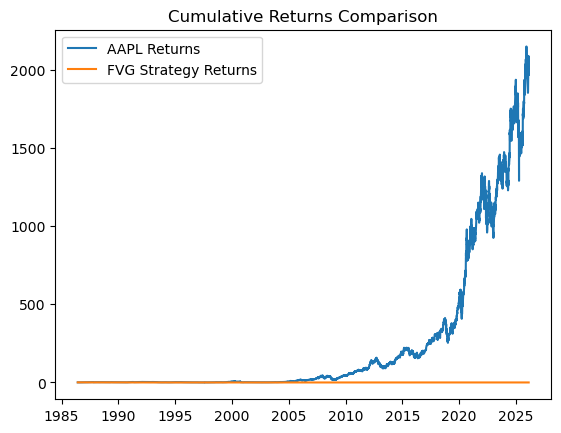

1793 trades taken
Bull FVG Average returns: 0.73%
897 Medium sized FVGs
Medium Bull FVG Average returns: 0.74%
1284 trades taken
Bear FVG Average returns: -0.66%
642 Medium sized FVGs
Medium Bear FVG Average returns: -0.74%


In [2]:
ticker = 'AAPL'
LOOKBACK = -10000
Holding_period = 5

def get_data():
    df = yf.download(ticker, period = '40y', auto_adjust=True, interval='1d')
    df.sort_index(inplace=True)
    df.columns = df.columns.get_level_values(0)

    return df.iloc[LOOKBACK:,:]

def bull_fvg(df):

    df['High_2prev'] = df['High'].shift(2)
    df['Bull_FVG'] = (df['Low'] > df['High_2prev']).astype(int)
    df['Bull_FVG_Val'] = (df['Low'] - df['High_2prev']) * df['Bull_FVG'] / df['Close']

    fvg_subset = df[df['Bull_FVG_Val'] > 0]

    
    plt.hist(fvg_subset['Bull_FVG_Val'], bins=10)
    plt.title("Bullish Fair Value Gap Values")

    return df

def bear_fvg(df):

    df['Low_2prev'] = df['Low'].shift(2)
    df['Bear_FVG'] = (df['High'] < df['Low_2prev']).astype(int)
    df['Bear_FVG_Val'] = (df['High'] - df['Low_2prev']) * df['Bear_FVG'] / df['Close']

    fvg_subset = df[df['Bear_FVG_Val'] < 0]

    plt.figure()
    plt.hist(fvg_subset['Bear_FVG_Val'], bins=10, color='red')
    plt.title("Bearish FairValue Gap Values")

    return df

def strategy(df):
    df['strategy'] = 0

    #generate signals
    df['strategy'] = np.where(df['Bear_FVG'] == 1, -1, 
                    np.where(df['Bull_FVG'] == 1, 1, 0))

    #shift strategy to avoid lookahead bias
    
    df['strategy'] = df['strategy'].ffill()
    df['strategy'] = df['strategy'].fillna(0)
    df['strategy'] = df['strategy'].shift(1)

    return df

def test_strategy(df):
    df['Asset_returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['strategy_returns'] = (1 + df['Close'].pct_change() * df['strategy']).cumprod() - 1

    plt.figure()
    plt.plot(df['Asset_returns'], label=f'{ticker} Returns')
    plt.plot(df['strategy_returns'], label='FVG Strategy Returns')
    plt.legend()
    plt.title('Cumulative Returns Comparison')
    plt.show()

    return df

def main():
    df = get_data()
    df = bull_fvg(df)
    df = bear_fvg(df)
    df = strategy(df)
    df = test_strategy(df)

    return df

df = main()
df

def assess_bull_FVG(df, Holding_period):

    df[f'Price_{Holding_period}_Periods'] = df["Close"].shift(-Holding_period) / df['Close']

    fvg_subset = df[df['Bull_FVG_Val'] > 0]
    print(f'{len(fvg_subset)} trades taken')
    print(f'Bull FVG Average returns: {round((fvg_subset[f'Price_{Holding_period}_Periods'].mean()-1) * 100, 2)}%')

    #dfn quantiles
    lower = fvg_subset["Bull_FVG_Val"].quantile(.25)
    upper = fvg_subset["Bull_FVG_Val"].quantile(.75)

    fvg_medium_val = fvg_subset[(fvg_subset["Bull_FVG_Val"] >= lower) & (fvg_subset["Bull_FVG_Val"] <= upper)]
    print(f'{len(fvg_medium_val)} Medium sized FVGs')
    print(f'Medium Bull FVG Average returns: {round((fvg_medium_val[f'Price_{Holding_period}_Periods'].mean()-1) * 100, 2)}%')

    return

def assess_bear_FVG(df, Holding_period):

    df[f'Price_{Holding_period}_Periods'] = df["Close"].shift(-Holding_period) / df['Close']

    fvg_subset = df[df['Bear_FVG_Val'] < 0]
    print(f'{len(fvg_subset)} trades taken')
    print(f'Bear FVG Average returns: {round((fvg_subset[f"Price_{Holding_period}_Periods"].mean()-1) * 100 * -1, 2)}%')

    #dfn quantiles
    lower = fvg_subset["Bear_FVG_Val"].quantile(.25)
    upper = fvg_subset["Bear_FVG_Val"].quantile(.75)

    fvg_medium_val = fvg_subset[(fvg_subset["Bear_FVG_Val"] >= lower) & (fvg_subset["Bear_FVG_Val"] <= upper)]
    print(f'{len(fvg_medium_val)} Medium sized FVGs')
    print(f'Medium Bear FVG Average returns: {round((fvg_medium_val[f'Price_{Holding_period}_Periods'].mean()-1) * 100 *-1, 2)}%')

    return 

assess_bull_FVG(df, Holding_period)
assess_bear_FVG(df, Holding_period)


